In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取数据，预览前5行
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
# 查看一下数据的基本信息。


train.info()
train.shape


test.info()
test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

(1934174, 28)

# 处理缺失数据

In [4]:
# 筛选缺失数据
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [5]:
# 删除缺失数据
train.drop(2744604, inplace = True)

# 处理参与比赛人数数据

In [6]:
# 创建一个新的特征：每场比赛的参与人数
# train
train['player_joined'] = train.groupby('matchId')['matchId'].transform('count')
# test
test['player_joined'] = test.groupby('matchId')['matchId'].transform('count')

D:\software\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='player_joined', ylabel='count'>

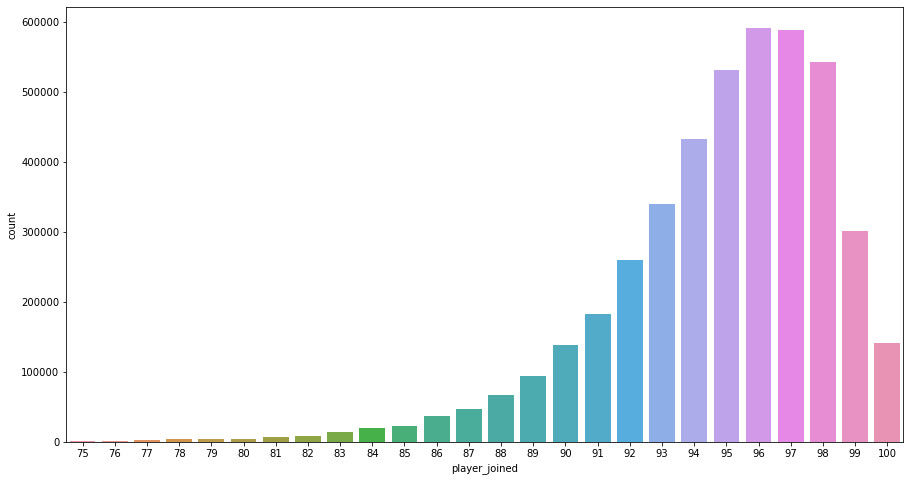

In [7]:
# 画出玩家超过75人的比赛场次
plt.subplots(figsize=(15,8))
sns.countplot(train[train['player_joined'] >= 75]['player_joined'])


In [8]:
# 将数据调整到相当于参赛人数为100人的标准下

# train
train['kills_Norm'] = train['kills'] * (1 + ((100 - train['player_joined']) / 100))
train['damageDealt_Norm'] = train['damageDealt'] * (1 + ((100 - train['player_joined']) / 100))
train['matchDuration_Norm'] = train['matchDuration'] * (1 + ((100 - train['player_joined']) / 100))

#test
test['kills_Norm'] = test['kills'] * (1 + ((100 - test['player_joined']) / 100))
test['damageDealt_Norm'] = test['damageDealt'] * (1 + ((100 - test['player_joined']) / 100))
test['matchDuration_Norm'] = test['matchDuration'] * (1 + ((100 - test['player_joined']) / 100))


# 处理开挂数据

In [9]:
# 创建一个新的特征：玩家移动的总距离（使用交通工具移动距离 + 步行移动距离 + 游泳移动距离）

train['total_distance']=train['rideDistance']+train['walkDistance']+train['swimDistance']
test['total_distance']=test['rideDistance']+test['walkDistance']+test['swimDistance']

# 统计出没有移动距离就有击杀人数的数据


train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['total_distance'] == 0))
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['total_distance'] == 0))

# 统计头部击杀率

train['headshot_Rate'] = train['headshotKills'] / train['kills']
# 击杀人数为0的头部击杀率为0
train['headshot_Rate'] = train['headshot_Rate'].fillna(0)


test['headshot_Rate'] = test['headshotKills'] / train['kills']
# 击杀人数为0的头部击杀率为0
test['headshot_Rate'] = test['headshot_Rate'].fillna(0)


In [10]:
# 剔除没有移动距离就有击杀人数的数据
train.drop(train[train['killsWithoutMoving']==True].index,inplace=True)

test.drop(test[test['killsWithoutMoving']==True].index,inplace=True)


In [11]:
# 剔除开车杀人大于10的数据

#test

train.drop(train[train['roadKills'] > 10].index,inplace=True)

#test 

test.drop(test[test['roadKills'] > 10].index,inplace=True)

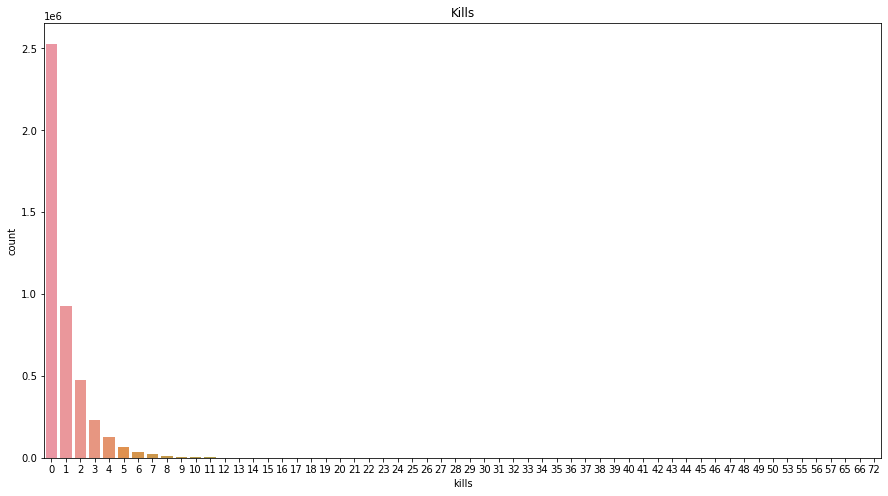

In [12]:
#画出击杀数据

plt.subplots(figsize = (15, 8))
sns.countplot(data = train,x = train['kills']).set_title('Kills')
plt.show()

In [13]:
# 剔除击杀量大于30的数据

#train
train.drop(train[train['kills'] > 30].index,inplace=True)

#test

test.drop(test[test['kills'] > 30].index,inplace=True)

D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


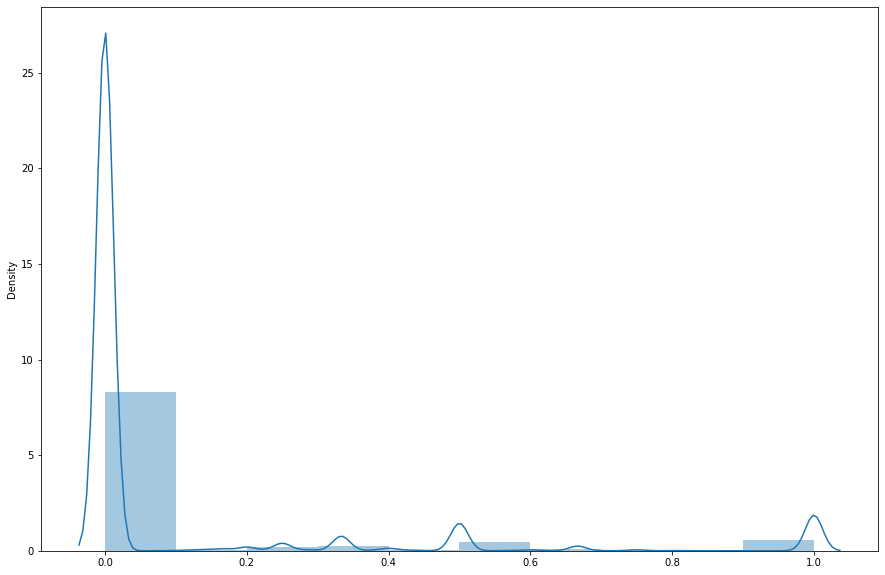

In [14]:
# 画出爆头率异常数据
plt.figure(figsize = (15, 10))
sns.distplot(x = train['headshot_Rate'],bins = 10)
plt.show()

In [15]:
# 剔除爆头率为1的异常数据

train.drop(train[train['headshot_Rate'] == 1].index,inplace=True)

test.drop(test[test['headshot_Rate'] == 1].index,inplace=True)


D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


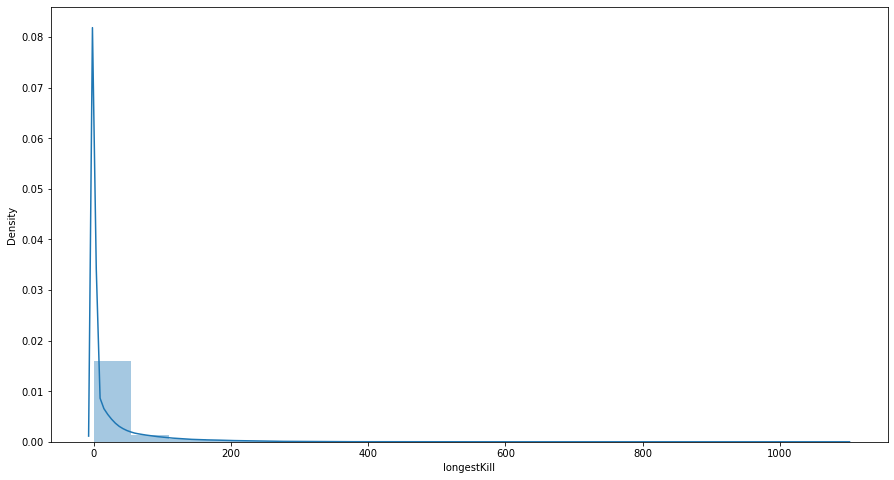

In [16]:
# 画出远距离击杀数据
plt.subplots(figsize=(15,8))
sns.distplot(train['longestKill'],bins=20)
plt.show()

In [17]:
# 剔除击杀距离超过1000米的数据
#train
train.drop(train[train['longestKill'] >= 1000].index,inplace=True)

#test
test.drop(test[test['longestKill'] >= 1000].index,inplace=True)

D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


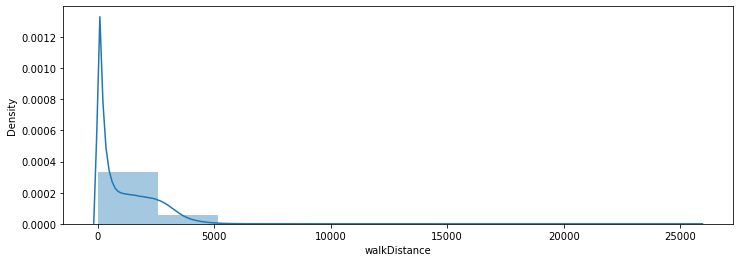

In [18]:
# 画出步行移动距离的数据图

plt.figure(figsize = (12,4))
sns.distplot(train['walkDistance'], bins = 10)
plt.show()

In [19]:
#剔除步行移动距离大于10000米的数据

#train
train.drop(train[train['walkDistance'] >= 10000].index,inplace = True)


#test
test.drop(test[test['walkDistance'] >= 10000].index,inplace = True)

D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


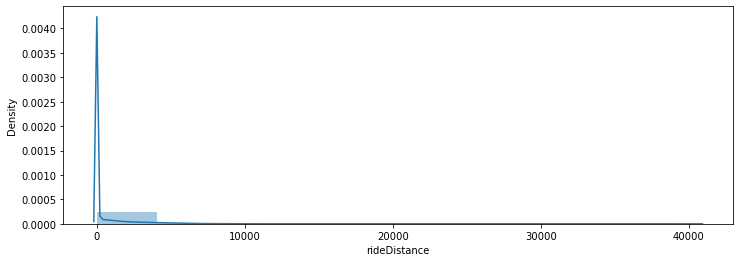

In [20]:
# 画出骑行移动距离的数据图

plt.subplots(figsize=(12,4))
sns.distplot(train['rideDistance'],bins=10)
plt.show()

In [21]:
#剔除骑行移动距离大于15000米的数据
#test

train.drop(train[train['rideDistance'] >= 15000].index, inplace = True)

#test

test.drop(test[test['rideDistance'] >= 15000].index, inplace = True)

D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


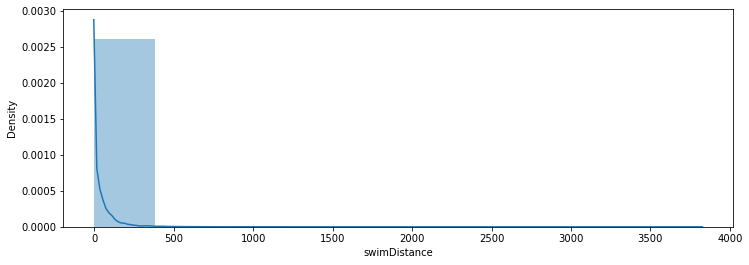

In [22]:
# 画出游泳移动距离的数据图

plt.subplots(figsize = (12,4))
sns.distplot(train['swimDistance'],bins = 10)
plt.show()

In [23]:
#剔除游泳距离大于1000米的数据
#test

train.drop(train[train['swimDistance'] >= 1000].index, inplace = True)

#test

test.drop(test[test['swimDistance'] >= 1000].index, inplace = True)

D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


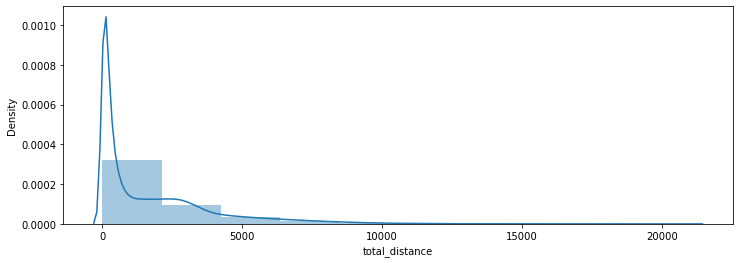

In [24]:
# 画出总移动距离的数据图

plt.subplots(figsize = (12,4))
sns.distplot(train['total_distance'],bins = 10)
plt.show()

In [25]:
#剔除总移动距离大于15000米的数据
#train
train.drop(train[train['total_distance'] >= 15000].index,inplace = True)

#test
test.drop(test[test['total_distance'] >= 15000].index,inplace = True)

D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


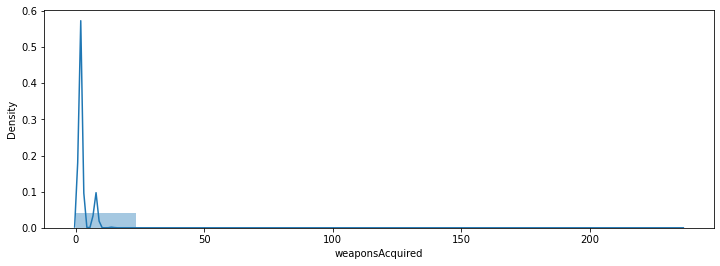

In [26]:
# 画出武器获得情况的数据图
plt.subplots(figsize = (12,4))
sns.distplot(train['weaponsAcquired'],bins = 10)
plt.show()

In [27]:
# 剔除武器获得50把以上的数据
#train
train.drop(train[train['weaponsAcquired'] >= 50].index,inplace = True)

#test
test.drop(test[test['weaponsAcquired'] >= 50].index,inplace = True)

D:\software\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


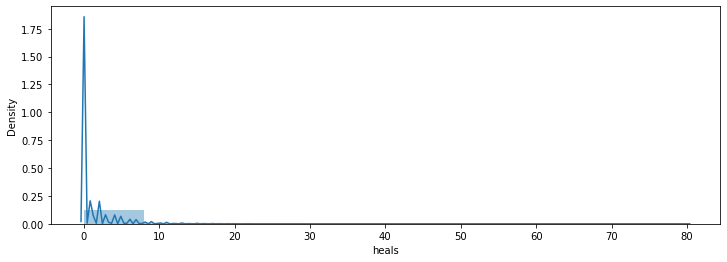

In [28]:
# 画出治疗量情况的数据图
plt.subplots(figsize = (12,4))
sns.distplot(train['heals'],bins = 10)
plt.show()

In [29]:
# 剔除治疗量超过40的数据
#train
train.drop(train[train['heals'] >= 40].index,inplace = True)

#test
test.drop(test[test['heals'] >= 40].index,inplace = True)

In [30]:
train.shape

(4189792, 36)

In [31]:
# 比赛模式
#train

train=pd.get_dummies(train,columns = ['matchType'])

#test

test=pd.get_dummies(test,columns = ['matchType'])

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4189792 entries, 0 to 4446965
Data columns (total 51 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Id                          object 
 1   groupId                     object 
 2   matchId                     object 
 3   assists                     int64  
 4   boosts                      int64  
 5   damageDealt                 float64
 6   DBNOs                       int64  
 7   headshotKills               int64  
 8   heals                       int64  
 9   killPlace                   int64  
 10  killPoints                  int64  
 11  kills                       int64  
 12  killStreaks                 int64  
 13  longestKill                 float64
 14  matchDuration               int64  
 15  maxPlace                    int64  
 16  numGroups                   int64  
 17  rankPoints                  int64  
 18  revives                     int64  
 19  rideDistance         

In [33]:
# 删除所有不重要的列

#train

train.drop(['killsWithoutMoving'],axis=1,inplace=True)
#test

test.drop(['killsWithoutMoving'],axis=1,inplace=True)

In [34]:
train.drop(['Id','groupId','matchId'],axis=1,inplace=True)

# 测试集保留Id
test_id=test['Id']

test.drop(['Id','groupId','matchId'],axis=1,inplace=True)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4189792 entries, 0 to 4446965
Data columns (total 47 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   assists                     int64  
 1   boosts                      int64  
 2   damageDealt                 float64
 3   DBNOs                       int64  
 4   headshotKills               int64  
 5   heals                       int64  
 6   killPlace                   int64  
 7   killPoints                  int64  
 8   kills                       int64  
 9   killStreaks                 int64  
 10  longestKill                 float64
 11  matchDuration               int64  
 12  maxPlace                    int64  
 13  numGroups                   int64  
 14  rankPoints                  int64  
 15  revives                     int64  
 16  rideDistance                float64
 17  roadKills                   int64  
 18  swimDistance                float64
 19  teamKills            

# 建立模型

In [36]:
# 取50000条数据作为训练样本
sample = 50000
df_sample = train.sample(sample)

In [37]:
# 特征数据和标签数据拆分
y = df_sample['winPlacePerc']
df = df_sample.drop(columns = ['winPlacePerc'])
data = np.array(df)
data_Y = np.array(y).reshape(-1, 1)
data.shape

(50000, 46)

In [38]:
# 参数
lr = 0.00000001
iterations = 3000
epochs = 1 # number of epochs for training
rng = np.random.default_rng(1)

# 切分数据集
m_train = 40000
m_test = sample - m_train
d = data.shape[1]
X_train = data[0:m_train,:].T
X_test = data[m_train:,:].T
y_train = data_Y[0:m_train].reshape((1,-1))
y_test = data_Y[m_train:].reshape((1,-1))

w = np.zeros((d, 1)).reshape((-1, 1))  # 权重
b = 0 # bias, scalar
v = np.ones((1, m_train))  # 偏差
costs_saved = [] 


Weights = [ 3.154e-07  2.272e-06  9.569e-05 -2.227e-07  1.223e-07  2.426e-06
 -7.745e-05  7.635e-05  1.075e-06  7.345e-07  2.425e-05 -3.193e-05
  5.703e-05  5.610e-05  2.721e-04  3.120e-07 -4.800e-05  4.195e-10
  8.035e-06 -1.824e-08 -8.891e-09  1.153e-04  6.310e-06  2.067e-04
  3.239e-05  1.112e-06  9.464e-05 -9.228e-05  7.537e-05  8.114e-08
  4.253e-09 -4.321e-10  8.970e-08  3.768e-07 -7.208e-10 -1.958e-09
  1.045e-09 -7.646e-09  0.000e+00 -1.952e-10 -1.052e-09 -2.188e-08
  1.020e-07  4.586e-07 -2.791e-07 -4.120e-07]
Bias = 0.000


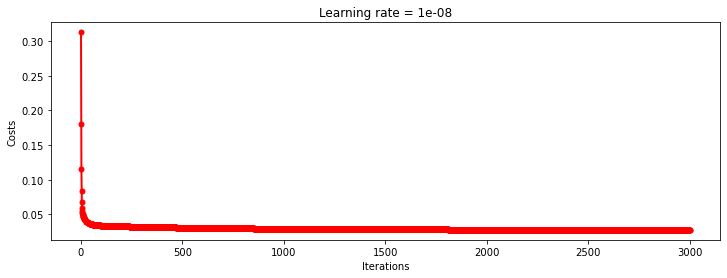

Trainset MSE = 0.028
Trainset RMSE = 0.166
Trainset MAE = 0.000
Trainset SMAPE = 44.758
Testset MSE = 0.027
Testset RMSE = 0.163
Testset MAE = 0.000
Testset SMAPE = 44.758


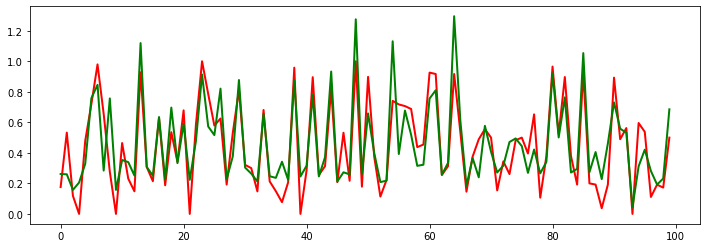

In [39]:
# 批梯度下降法
for i in range(iterations):
    
    y_hat = np.dot(w.T, X_train) + b * v
    e = y_hat - y_train
    b = b - 2. * lr * np.dot(v, e.T) / m_train
    w = w - 2. * lr * np.dot(X_train, e.T) / m_train
     
    costs = np.dot(e, e.T) / m_train 
    costs_saved.append(costs.item(0))
    
print('Weights =', np.array2string(np.squeeze(w, axis=1), precision=3))
print(f'Bias = {b.item(0):.3f}')

# 画出损失函数曲线
plt.subplots(figsize = (12,4))
plt.plot(range(1, np.size(costs_saved) + 1), costs_saved, 'r-o', linewidth=2, markersize=5)
plt.ylabel('Costs')
plt.xlabel('Iterations')
plt.title('Learning rate = ' + str(lr))
plt.show()

# 模型评估

# trainset RMSE
y_hat = np.dot(w.T, X_train) + b # broadcasting
e = y_hat - y_train
mse = np.dot(e, e.T) / m_train
rmse = np.sqrt(mse)
mae = abs(e) / m_train
smape = 2.0 * np.mean(np.abs(y_hat - y_train) / (np.abs(y_hat) + np.abs(y_train))) * 100
print(f'Trainset MSE = {mse.item(0):.3f}')
print(f'Trainset RMSE = {rmse.item(0):.3f}')
print(f'Trainset MAE = {mae.item(0):.3f}')
print(f'Trainset SMAPE = {smape.item(0):.3f}')

# testset RMSE
y_hat_test = np.dot(w.T, X_test) + b # broadcasting
e_test = y_hat_test - y_test
mse_test = np.dot(e_test, e_test.T) / m_test
rmse_test = np.sqrt(mse_test)
mae_test = abs(e) / m_train
smape_test = 2.0 * np.mean(np.abs(y_hat - y_train) / (np.abs(y_hat) + np.abs(y_train))) * 100
print(f'Testset MSE = {mse_test.item(0):.3f}')
print(f'Testset RMSE = {rmse_test.item(0):.3f}')
print(f'Testset MAE = {mae_test.item(0):.3f}')
print(f'Testset SMAPE = {smape_test.item(0):.3f}')

# 真实值与预测值比较的折线图
y_train = y_train.reshape((-1,1))
y_hat = y_hat.reshape((-1,1))
plt.subplots(figsize = (12,4))
plt.plot(y_train[:100], "r-", linewidth=2, label="true")
plt.plot(y_hat[:100], "g-", linewidth=2, label="predict")
plt.show()